In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv('./hearthstone_minions.csv')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [33]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

columns_to_drop = ['url', 'card_name', 'CARDTYPE', 'COLLECTIBLE', 'ELITE', 'HAS_DIAMOND_QUALITY', 'MAX_SIDEBOARD_CARDS', 
                   'DECK_RULE_MOD_DECK_SIZE', 'TAG_SCRIPT_DATA_NUM_1', 'ENCHANTMENT_BIRTH_VISUAL', 
                   'ENCHANTMENT_IDLE_VISUAL', 'FACTION', 'AttackVisualType', 'DONT_PICK_FROM_SUBSETS', 
                   'IS_BACON_POOL_MINION', 'DECK_ACTION_COST', 'COLLECTION_RELATED_CARD_DATABASE_ID', 
                   'FORGES_INTO', 'TRIGGER_VISUAL', 'MINI_SET', 'TECH_LEVEL', 'MULTIPLE_CLASSES', 
                   'COST_UNHOLY', 'COST_FROST', 'COST_BLOOD', 'TAG_SCRIPT_DATA_NUM_2', 
                   'TRANSFORMED_FROM_CARD_VISUAL_TYPE', 'DECK_RULE_COUNT_AS_COPY_OF_CARD_ID', 'DevState',
                   'PLAYER_TAG_THRESHOLD_TAG_ID', 'PLAYER_TAG_THRESHOLD_VALUE', 'ENTITY_TAG_THRESHOLD_TAG_ID', 'ENTITY_TAG_THRESHOLD_VALUE',
                   'DISPLAY_CARD_ON_MOUSEOVER', 'USE_DISCOVER_VISUALS']
df = df.drop(columns=columns_to_drop, errors='ignore')

df['times_played'] = df['times_played'].str.replace(',', '').astype(int)
df = df[df['times_played'] >= 10]

valid_counts = df.count()
columns_to_drop = valid_counts[valid_counts < 5].index
df = df.drop(columns=columns_to_drop)

df = df[(df['avg_copies'] != '-') & (df['deck_winrate'] != '-')]

df['in_perc_of_decks'] = df['in_perc_of_decks'].str.replace('%', '').astype(float) / 100
df['deck_winrate'] = df['deck_winrate'].str.replace('%', '').astype(float) / 100
df['avg_copies'] = df['avg_copies'].astype(float)

df = df.fillna(0)

df['DISCARD_CARDS'] = df['DISCARD_CARDS'].apply(lambda x: 1 if x != 0 else 0)
df['MULTI_CLASS_GROUP'] = df['MULTI_CLASS_GROUP'].apply(lambda x: 1 if x != 0 else 0)
df['RACE'] = pd.factorize(df['CARDRACE'])[0] + 1
df['CLASS'] = pd.factorize(df['CLASS'])[0] + 1
df['CARDRACE'] = df['CARDRACE'].apply(lambda x: 1 if x != 0 else 0)
df['MANATHIRST'] = df['MANATHIRST'].apply(lambda x: 1 if x != 0 else 0)
df['avg_copies'] = df['avg_copies'] * df["in_perc_of_decks"]

# df['Keyword'] = df.iloc[:, 10:-1].sum(axis=1)
# df['Size'] = np.sqrt(df['HEALTH'] * df['ATK'])
# df['SizeTrue'] = df['Size'] + 0.75 * df['Keyword']
# df['Inflation'] = df['SizeTrue'] / df['COST']
# df = df[df['CLASS'] != 13]
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 2351 entries, 0 to 2350
Data columns (total 63 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   in_perc_of_decks       2351 non-null   float64
 1   avg_copies             2351 non-null   float64
 2   deck_winrate           2351 non-null   float64
 3   times_played           2351 non-null   int32  
 4   CLASS                  2351 non-null   int64  
 5   RARITY                 2351 non-null   float64
 6   COST                   2351 non-null   float64
 7   HEALTH                 2351 non-null   float64
 8   ATK                    2351 non-null   float64
 9   BATTLECRY              2351 non-null   float64
 10  DISCOVER               2351 non-null   float64
 11  MANATHIRST             2351 non-null   int64  
 12  CARDRACE               2351 non-null   int64  
 13  TAUNT                  2351 non-null   float64
 14  TITAN                  2351 non-null   float64
 15  AURA     

In [34]:
# decision tree model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Assuming 'df' is already preprocessed as provided
# Define input features (X) and target variables (y)
X = df.drop(columns=['deck_winrate', 'in_perc_of_decks','times_played', 'RACE', 'CLASS', 'deck_winrate'])
y = df[['deck_winrate', 'in_perc_of_decks','times_played']]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Regressor for multi-output regression
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)

# Predict on the test set
y_pred = decision_tree.predict(X_test)

# Evaluate the model using Mean Squared Error
mse_deck_winrate = mean_squared_error(y_test['deck_winrate'], y_pred[:, 0])
mse_in_perc_of_decks = mean_squared_error(y_test['in_perc_of_decks'], y_pred[:, 1])
mse_times_played = mean_squared_error(y_test['times_played'], y_pred[:, 2])

print("Mean Squared Error for 'deck_winrate':", mse_deck_winrate)
print("Mean Squared Error for 'in_perc_of_decks':", mse_in_perc_of_decks)
print("Mean Squared Error for 'times_played':", mse_times_played)


# Calculate R² scores for each target
r2_deck_winrate = r2_score(y_test['deck_winrate'], y_pred[:, 0])
r2_in_perc_of_decks = r2_score(y_test['in_perc_of_decks'], y_pred[:, 1])
r2_times_played = r2_score(y_test['times_played'], y_pred[:, 2])

# Print R² scores (accuracy)
print("R² Score for 'deck_winrate':", r2_deck_winrate)
print("R² Score for 'in_perc_of_decks':", r2_in_perc_of_decks)
print("R² Score for 'times_played':", r2_times_played)


Mean Squared Error for 'deck_winrate': 0.011968819532908704
Mean Squared Error for 'in_perc_of_decks': 6.97859872611465e-06
Mean Squared Error for 'times_played': 127347.2101910828
R² Score for 'deck_winrate': -0.874749005118586
R² Score for 'in_perc_of_decks': 0.8734462699314345
R² Score for 'times_played': 0.7507607141751298


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest Regressor for multi-output regression
random_forest = RandomForestRegressor(random_state=42, n_estimators=100)  # n_estimators sets the number of trees

# Train the Random Forest Regressor
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = random_forest.predict(X_test)

# Evaluate the model using R² score (accuracy)
r2_deck_winrate_rf = r2_score(y_test['deck_winrate'], y_pred_rf[:, 0])
r2_in_perc_of_decks_rf = r2_score(y_test['in_perc_of_decks'], y_pred_rf[:, 1])
r2_times_played_rf = r2_score(y_test['times_played'], y_pred_rf[:, 2])

# Evaluate the model using Mean Squared Error
mse_deck_winrate_rf = mean_squared_error(y_test['deck_winrate'], y_pred_rf[:, 0])
mse_in_perc_of_decks_rf = mean_squared_error(y_test['in_perc_of_decks'], y_pred_rf[:, 1])
mse_times_played_rf = mean_squared_error(y_test['times_played'], y_pred_rf[:, 2])

# Print the results
print("Random Forest R² Score for 'deck_winrate':", r2_deck_winrate_rf)
print("Random Forest R² Score for 'in_perc_of_decks':", r2_in_perc_of_decks_rf)
print("Random Forest R² Score for 'times_played':", r2_times_played_rf)

print("Random Forest Mean Squared Error for 'deck_winrate':", mse_deck_winrate_rf)
print("Random Forest Mean Squared Error for 'in_perc_of_decks':", mse_in_perc_of_decks_rf)
print("Random Forest Mean Squared Error for 'times_played':", mse_times_played_rf)


Random Forest R² Score for 'deck_winrate': -0.009519662990219446
Random Forest R² Score for 'in_perc_of_decks': 0.9700946271633379
Random Forest R² Score for 'times_played': 0.8386287127938465
Random Forest Mean Squared Error for 'deck_winrate': 0.006445000705834999
Random Forest Mean Squared Error for 'in_perc_of_decks': 1.649082936305732e-06
Random Forest Mean Squared Error for 'times_played': 82451.62139120938


In [37]:
# linear regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Separate the input (X) and output (y) variables
X = df.drop(columns=['deck_winrate', 'in_perc_of_decks','times_played', 'RACE', 'CLASS', 'deck_winrate'])
y = df[['deck_winrate', 'in_perc_of_decks','times_played']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a multi-output linear regression model
model = LinearRegression()

# Train the model
# weights = np.array([1, 1])
# model = train_weighted_model(X_train, y_train, weights)
# model = optimize_hyperparameters(X_train, y_train)

model.fit(X_train, y_train)

# Get the coefficients
coefficients = model.coef_
intercepts = model.intercept_

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

print(mse)
print(r2)

[5.90386872e-03 4.65670377e-06 4.31869057e+04]
[0.07524113 0.91555278 0.91547617]


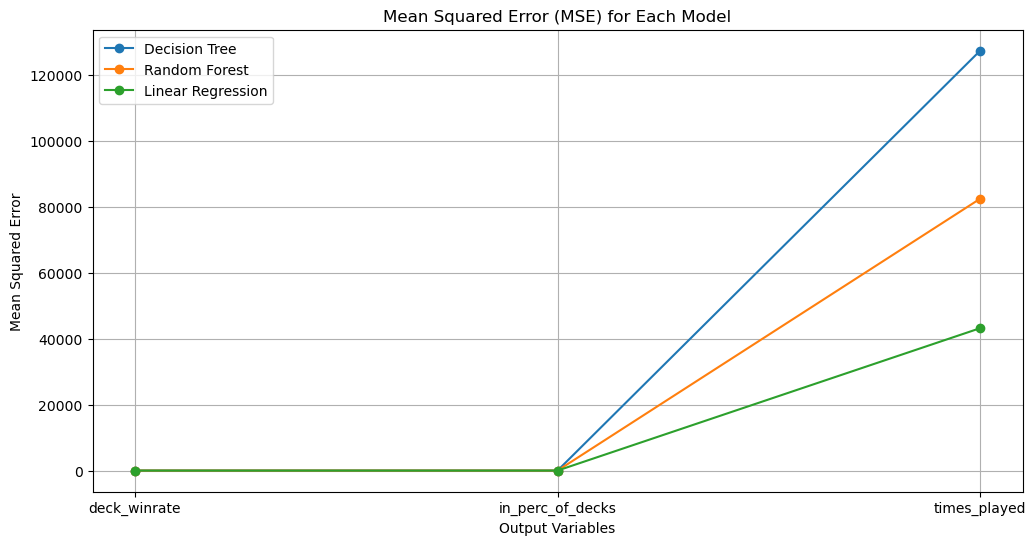

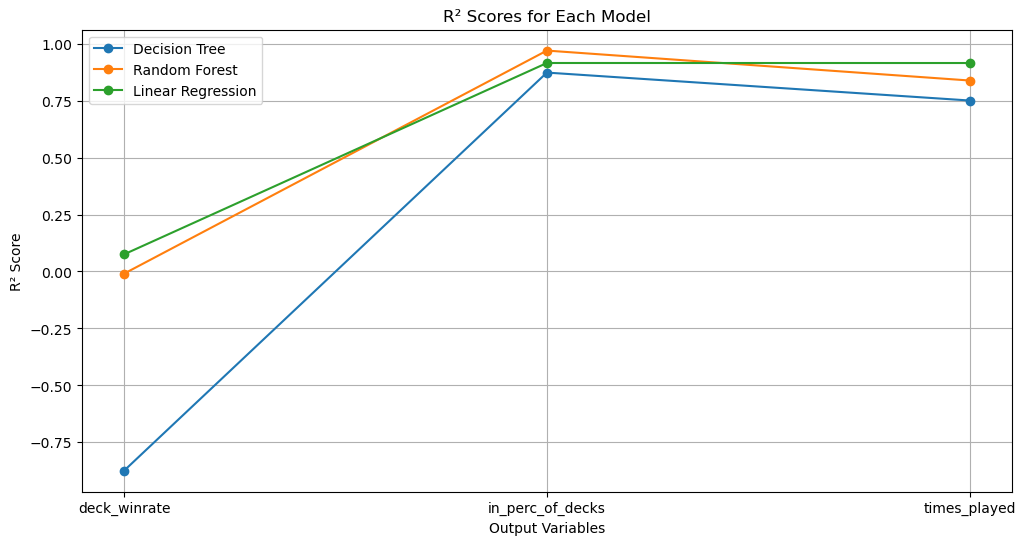

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Define the y-dimensions and model names
y_dimensions = ['deck_winrate', 'in_perc_of_decks', 'times_played']
models = ['Decision Tree', 'Random Forest', 'Linear Regression']

# MSE values for each model
mse_values = {
    'Decision Tree': [mse_deck_winrate, mse_in_perc_of_decks, mse_times_played],
    'Random Forest': [mse_deck_winrate_rf, mse_in_perc_of_decks_rf, mse_times_played_rf],
    'Linear Regression': list(mse)  # Ensure this matches the length of y_dimensions
}

# R2 values for each model
r2_values = {
    'Decision Tree': [r2_deck_winrate, r2_in_perc_of_decks, r2_times_played],
    'Random Forest': [r2_deck_winrate_rf, r2_in_perc_of_decks_rf, r2_times_played_rf],
    'Linear Regression': list(r2)  # Ensure this matches the length of y_dimensions
}

# Ensure all lists in mse_values and r2_values have the same length as y_dimensions
for model in models:
    if len(mse_values[model]) != len(y_dimensions):
        raise ValueError(f"MSE values for {model} do not match the number of y_dimensions.")
    if len(r2_values[model]) != len(y_dimensions):
        raise ValueError(f"R2 values for {model} do not match the number of y_dimensions.")

# Plot MSE
plt.figure(figsize=(12, 6))
for model in models:
    plt.plot(y_dimensions, mse_values[model], marker='o', label=model)

plt.title('Mean Squared Error (MSE) for Each Model')
plt.xlabel('Output Variables')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot R2
plt.figure(figsize=(12, 6))
for model in models:
    plt.plot(y_dimensions, r2_values[model], marker='o', label=model)

plt.title('R² Scores for Each Model')
plt.xlabel('Output Variables')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.show()
